<a href="https://colab.research.google.com/github/desiredominique/xception_ml/blob/main/Teste_Seios_Piriformes_XCeption.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Teste com XCeption**

In [ ]:
# importando os pacotes

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import io
import requests

from PIL import Image

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
from keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras import models
from scipy.ndimage import zoom

from keras.models import load_model

In [ ]:
# testes de aplicação de filtros com tensorflow

example_img = tf.io.read_file('/content/drive/MyDrive/Seios Piriformes/1/01_000001.jpg')

example_img = tf.io.decode_jpeg(example_img, channels = 1)

example_img = tf.image.convert_image_dtype(example_img, dtype=tf.float32)

example_img = tf.expand_dims(example_img,axis=0)

horizontal_sobel = np.array([[1,2,1],[0,0,0],[-1,-2,-1]])

kernel = tf.constant(horizontal_sobel)
kernel = tf.reshape(kernel,shape=[*kernel.shape,1,1])
kernel = tf.cast(kernel, dtype=tf.float32)

In [ ]:
# dados de treinamento

ds_train = image_dataset_from_directory(
    '/content/drive/MyDrive/Seios Piriformes',
    labels='inferred',
    label_mode = "categorical",
    image_size=[128, 128],
    validation_split = 0.3,
    subset="training",
    interpolation='nearest',
    batch_size=64,
    shuffle=True,
    seed=42
)

# dados de validação

ds_valid = image_dataset_from_directory(
    '/content/drive/MyDrive/Seios Piriformes',
    labels='inferred',
    label_mode = "categorical",
    image_size=[128, 128],
    validation_split = 0.3,
    subset="validation",
    interpolation='nearest',
    batch_size=64,
    shuffle=True,
    seed=42
)


# nomes das classes

class_names = ds_train.class_names
class_names

Found 432 files belonging to 2 classes.
Using 303 files for training.
Found 432 files belonging to 2 classes.
Using 129 files for validation.


['1', '5']

In [ ]:
# forma de um vetor
for image,label in ds_train.take(1):
    print("shape:",image.shape)

shape: (64, 128, 128, 3)


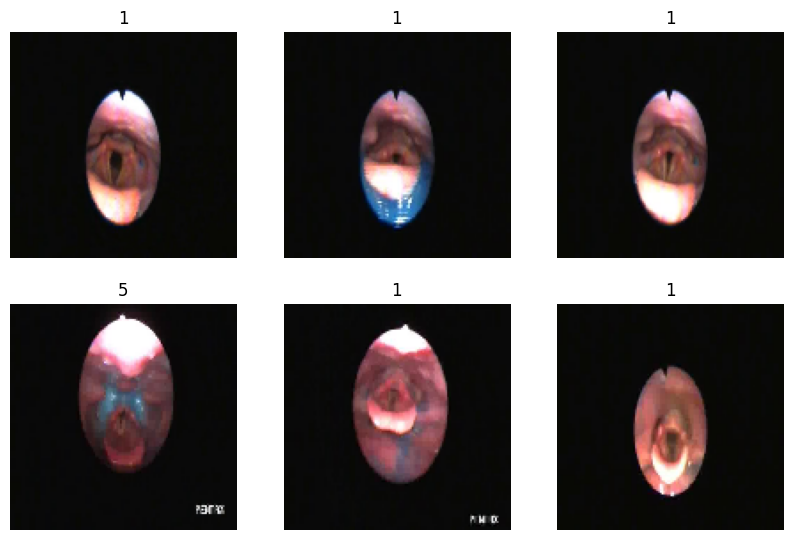

In [ ]:
# visualização de 5 imagens

for image,labels in ds_train.take(1):#1 lote de imagens
    plt.figure(figsize=(10,10))
    for i in range(6): # mostrar 5 imagens
        ax = plt.subplot(3,3,i+1)
        plt.imshow(image[i].numpy())
        plt.title(class_names[labels[i].numpy().tolist().index(1)])
        plt.axis("off")

In [ ]:
# mantem as imagens na memoria para que nao se repitam no treinamento

AUTOTUNE = tf.data.AUTOTUNE

ds_train = ds_train.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
ds_valid = ds_valid.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
tf.random.set_seed(12)
np.random.seed(12)

In [ ]:
# modelo com adição das camadas de Head

data_augmentation = keras.Sequential([
    preprocessing.RandomZoom(0.1),
    preprocessing.RandomFlip(mode="horizontal"),
    preprocessing.RandomRotation(factor=0.1),

])

In [ ]:
#Criação do Modelo # Criação das camadas
model = keras.Sequential([


    layers.InputLayer(input_shape=[128, 128, 3]),

    #preprocessamento
    data_augmentation,

    layers.Rescaling(1./255),


    #Base,
    layers.BatchNormalization(),#camada de normalização dos dados
    layers.Conv2D(filters=64, kernel_size=3, activation="relu", padding='same'),
    layers.MaxPool2D(),
    layers.Dropout(0.25),

    layers.BatchNormalization(),
    layers.Conv2D(filters=64, kernel_size=3, activation="relu", padding='same'),
    layers.Conv2D(filters=64, kernel_size=3, activation="relu", padding='same'),
    layers.MaxPool2D(),
    layers.Dropout(0.25),





    # Head
    layers.BatchNormalization(),
    layers.GlobalMaxPooling2D(),
    layers.Dense(len(class_names),activation="softmax") #camada de output
])

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 128, 128, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 128, 128, 3)       0         
                                                                 
 batch_normalization (Batch  (None, 128, 128, 3)       12        
 Normalization)                                                  
                                                                 
 conv2d (Conv2D)             (None, 128, 128, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2  (None, 64, 64, 64)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 64, 64, 64)       

In [ ]:
# teste da classificação

test_images1 = [image.numpy() for image,labels in ds_valid.take(-1)][0]
test_labels1 = [labels.numpy() for image,labels in ds_valid.take(-1)][0]

test_labels1 = np.argmax(test_labels1,axis=-1)
predict_labels1 = np.argmax(model.predict(test_images1),axis=-1)

print(classification_report(test_labels1,predict_labels1,target_names=class_names))

2/2 [==============================] - 1s 588ms/step
              precision    recall  f1-score   support

           1       0.52      1.00      0.68        33
           5       0.00      0.00      0.00        31

    accuracy                           0.52        64
   macro avg       0.26      0.50      0.34        64
weighted avg       0.27      0.52      0.35        64



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# dados pré-treinados

pretrained_base = keras.applications.xception.Xception(include_top=False,input_shape=(128,128,3),weights=None)

In [ ]:
# importação da camada XCeption

weights_path = "/content/drive/MyDrive/xception_weights_tf_dim_ordering_tf_kernels_notop.h5"
pretrained_base.load_weights(weights_path)

In [ ]:
# modelos XCeption não tem treinamento de camadas do modelo base

for layer in pretrained_base.layers:
    layer.trainable = False

In [ ]:
from keras.src.engine.training import optimizer
# adição da classificação head
inputs = keras.Input(shape=(128, 128, 3))
x = data_augmentation(inputs)

# Pesos XCeption pre-treinados necessitam que a entrada seja escalavel
# de (0, 255) a uma faixa de (-1., +1.)

x = layers.Rescaling(scale=1./127.5,offset=-1)(x)
x = pretrained_base(x, training=False)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.2)(x)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.2)(x)

outputs = layers.Dense(len(class_names),activation="softmax")(x)
model_tl = tf.keras.Model(inputs, outputs)

In [ ]:
model_tl.summary()

model_tl.compile(
    optimizer= tf.keras.optimizers.Adam(learning_rate=0.001,epsilon=0.001),
    loss="categorical_crossentropy",
    metrics=['accuracy'],
)

reduce_lr_tf1 = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',factor=0.1,min_delta=0.001,
                              patience=2, min_lr=0.0001)

early_stop = tf.keras.callbacks.EarlyStopping(monitor="val_loss",patience=5,restore_best_weights=True,mode="min",
                                             min_delta=0.001)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 128, 128, 3)       0         
                                                                 
 rescaling_1 (Rescaling)     (None, 128, 128, 3)       0         
                                                                 
 xception (Functional)       (None, 4, 4, 2048)        20861480  
                                                                 
 batch_normalization_7 (Bat  (None, 4, 4, 2048)        8192      
 chNormalization)                                                
                                                                 
 dropout_2 (Dropout)         (None, 4, 4, 2048)        0         
                                                             

In [ ]:
# treinamento

history_tl = model_tl.fit(
    ds_train,
    validation_data=ds_valid,
    epochs=25,
    callbacks=[reduce_lr_tf1,early_stop]
)

Epoch 1/25
5/5 [==============================] - 41s 7s/step - loss: 0.8478 - accuracy: 0.5776 - val_loss: 0.6589 - val_accuracy: 0.6667 - lr: 0.0010
Epoch 2/25
5/5 [==============================] - 32s 7s/step - loss: 0.4387 - accuracy: 0.7954 - val_loss: 0.7294 - val_accuracy: 0.6357 - lr: 0.0010
Epoch 3/25
5/5 [==============================] - 35s 8s/step - loss: 0.3122 - accuracy: 0.8779 - val_loss: 0.7761 - val_accuracy: 0.6434 - lr: 0.0010
Epoch 4/25
5/5 [==============================] - 34s 7s/step - loss: 0.2954 - accuracy: 0.8878 - val_loss: 0.7490 - val_accuracy: 0.6434 - lr: 1.0000e-04
Epoch 5/25
5/5 [==============================] - 31s 7s/step - loss: 0.3244 - accuracy: 0.8812 - val_loss: 0.7226 - val_accuracy: 0.6434 - lr: 1.0000e-04
Epoch 6/25
5/5 [==============================] - 33s 7s/step - loss: 0.2888 - accuracy: 0.8878 - val_loss: 0.6940 - val_accuracy: 0.6589 - lr: 1.0000e-04


In [ ]:
model_tl.save("my_model.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2/2 [==============================] - 9s 5s/step


<Axes: title={'center': 'Matriz de confusão para os dados testados'}>

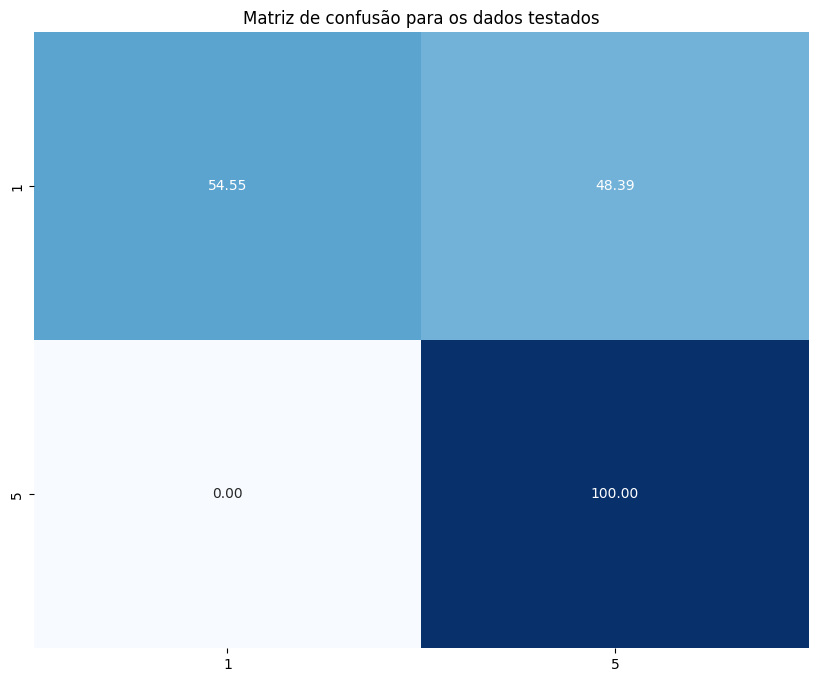

In [ ]:
# matriz de confusão

cn1 = confusion_matrix(test_labels1,np.argmax(model_tl.predict(test_images1),axis=-1))
plt.figure(figsize=(10,8))
plt.title("Matriz de confusão para os dados testados")
sns.heatmap((cn1/np.sum(cn1,axis=-1)*100), annot=True, cmap='Blues',fmt=".2f",cbar=False,yticklabels=class_names,
           xticklabels=class_names)

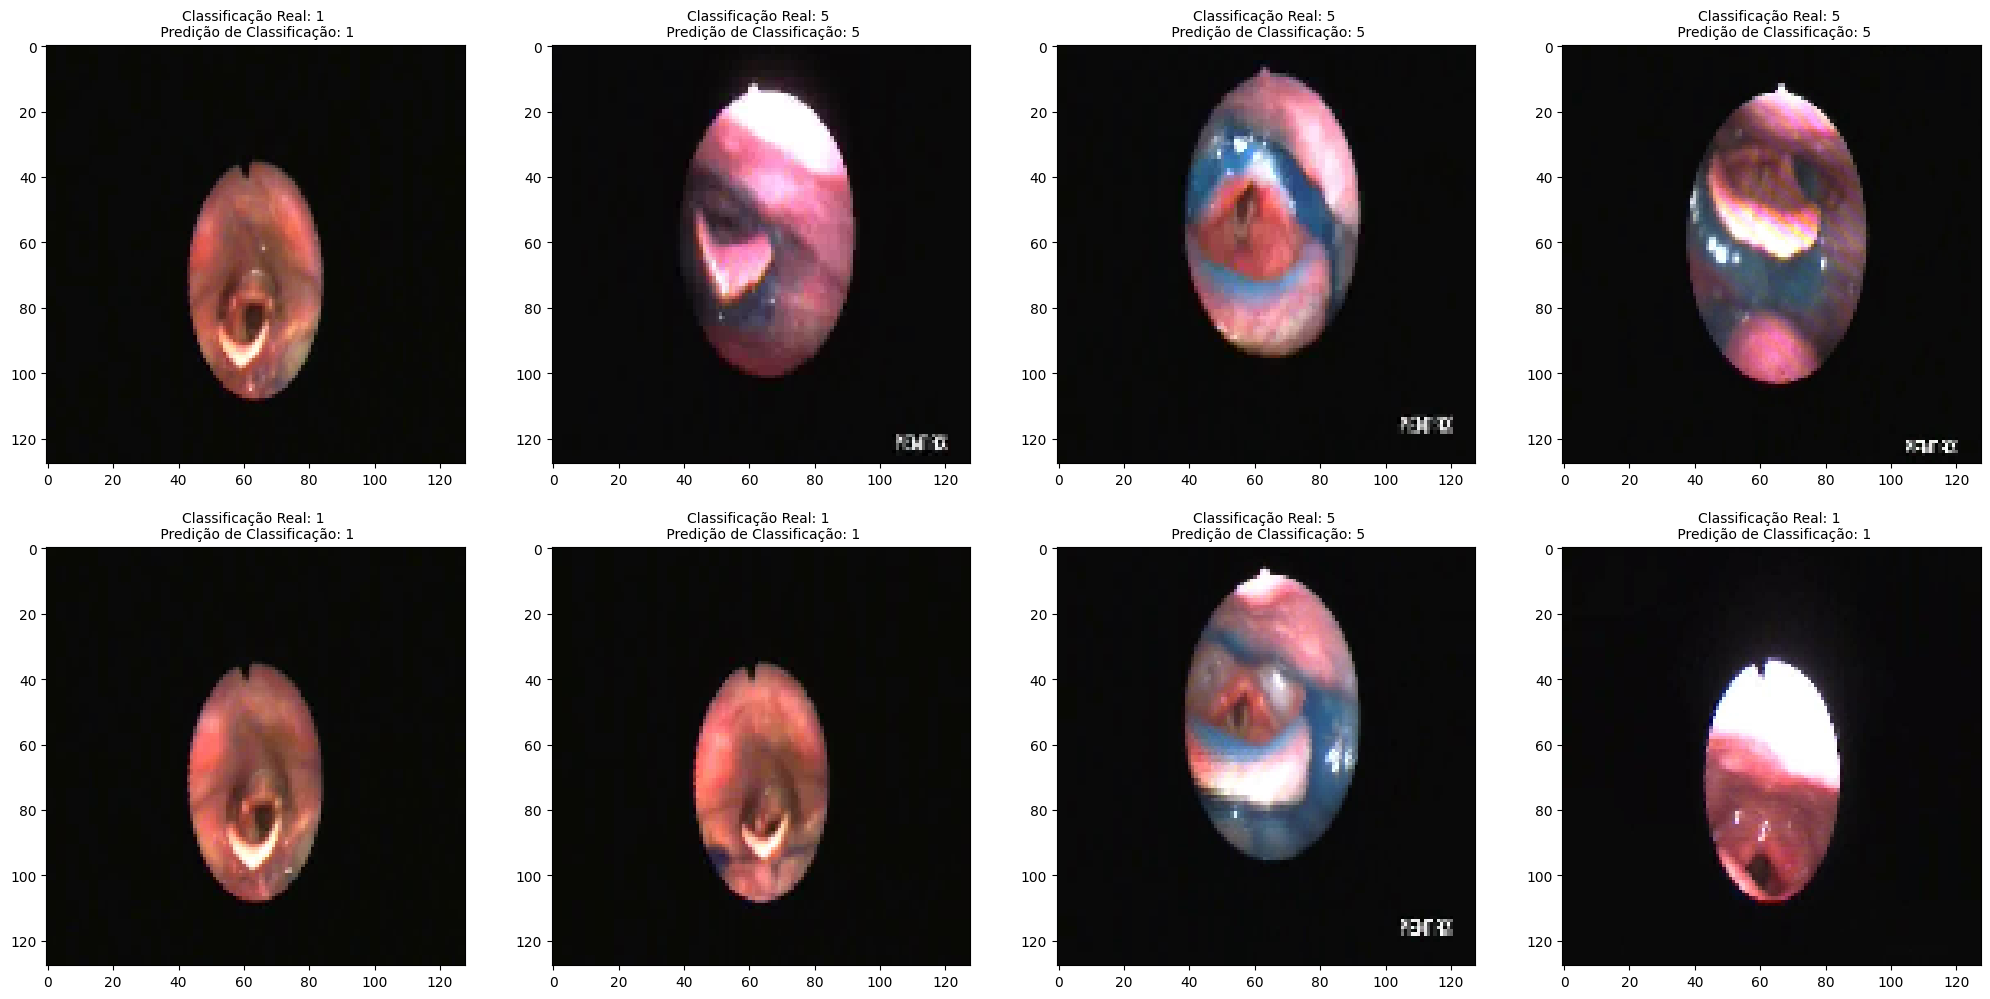

In [ ]:
# visualização das predições

plt.figure(figsize=(25,25))
for i in range(8): #mostrar 8 predições
    ax = plt.subplot(4,4,i+1)
    plt.imshow(test_images1[i])
    plt.title(f"Classificação Real: {class_names[test_labels1[i]]} \n Predição de Classificação: {class_names[test_labels1[i]]}",
             fontsize=10)

In [ ]:
new_model = load_model("./my_model.h5")

In [ ]:
new_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 128, 128, 3)       0         
                                                                 
 rescaling_1 (Rescaling)     (None, 128, 128, 3)       0         
                                                                 
 xception (Functional)       (None, 4, 4, 2048)        20861480  
                                                                 
 batch_normalization_7 (Bat  (None, 4, 4, 2048)        8192      
 chNormalization)                                                
                                                                 
 dropout_2 (Dropout)         (None, 4, 4, 2048)        0         
                                                             

In [ ]:
# ajuste fino nas últimas camadas

fine_tune_at = 70

for layer in new_model.layers[3].layers[fine_tune_at:] :
  layer.trainable = True

In [ ]:
new_model.compile(
    optimizer= keras.optimizers.Adam(learning_rate=0.0001,epsilon=0.001), #aplicando um learning rate menor
    loss="categorical_crossentropy",
    metrics=['accuracy'],
)

In [ ]:
reduce_lr_tl2 = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                              patience=2, min_lr=0.000001)

In [ ]:
history_fine = new_model.fit(
    ds_train,
    validation_data=ds_valid,
    epochs=20,
    callbacks=[reduce_lr_tl2,early_stop]
)

Epoch 1/20
5/5 [==============================] - 90s 13s/step - loss: 0.5058 - accuracy: 0.7921 - val_loss: 0.6339 - val_accuracy: 0.6589 - lr: 1.0000e-04
Epoch 2/20
5/5 [==============================] - 60s 12s/step - loss: 0.3132 - accuracy: 0.8647 - val_loss: 0.5667 - val_accuracy: 0.7054 - lr: 1.0000e-04
Epoch 3/20
5/5 [==============================] - 60s 12s/step - loss: 0.2306 - accuracy: 0.8977 - val_loss: 0.5000 - val_accuracy: 0.7597 - lr: 1.0000e-04
Epoch 4/20
5/5 [==============================] - 60s 13s/step - loss: 0.1638 - accuracy: 0.9406 - val_loss: 0.4668 - val_accuracy: 0.7984 - lr: 1.0000e-04
Epoch 5/20
5/5 [==============================] - 61s 12s/step - loss: 0.1329 - accuracy: 0.9571 - val_loss: 0.4374 - val_accuracy: 0.8140 - lr: 1.0000e-04
Epoch 6/20
5/5 [==============================] - 60s 12s/step - loss: 0.0825 - accuracy: 0.9802 - val_loss: 0.4646 - val_accuracy: 0.8062 - lr: 1.0000e-04
Epoch 7/20
5/5 [==============================] - 60s 12s/step -

In [ ]:
# relatório da classificação

test_images2 = [image.numpy() for image,labels in ds_valid.take(-1)][0]
test_labels2 = [labels.numpy() for image,labels in ds_valid.take(-1)][0]

test_labels2 = np.argmax(test_labels2,axis=-1)
predict_labels2 = np.argmax(new_model.predict(test_images2),axis=-1)

print(classification_report(test_labels2,predict_labels2,target_names=class_names))

2/2 [==============================] - 6s 3s/step
              precision    recall  f1-score   support

           1       1.00      0.79      0.88        33
           5       0.82      1.00      0.90        31

    accuracy                           0.89        64
   macro avg       0.91      0.89      0.89        64
weighted avg       0.91      0.89      0.89        64



2/2 [==============================] - 4s 2s/step


<Axes: title={'center': 'Confusion Matrix for the test data'}>

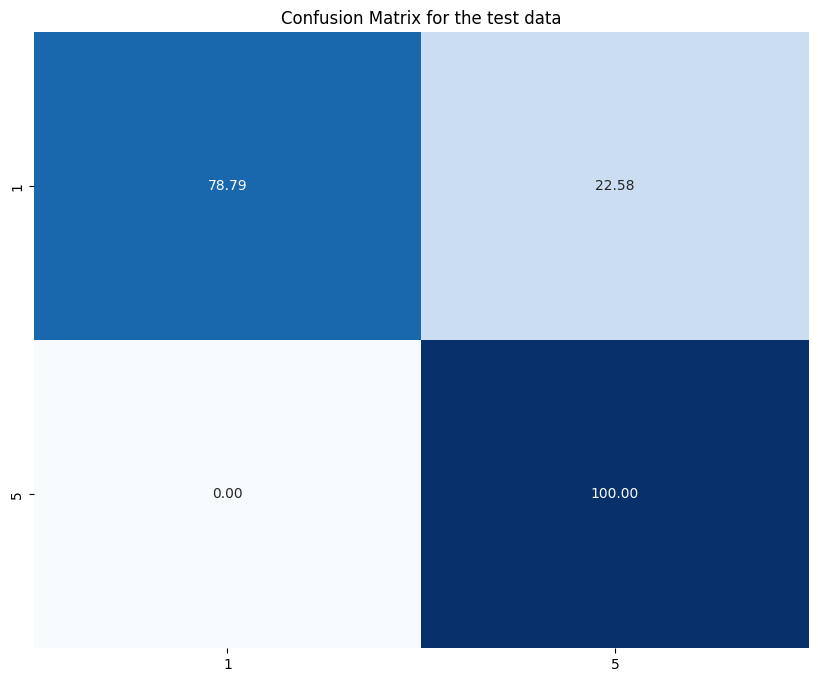

In [ ]:
#plot da confusion matrix
cn2 = confusion_matrix(test_labels2,np.argmax(new_model.predict(test_images2),axis=-1))
plt.figure(figsize=(10,8))
plt.title("Confusion Matrix for the test data")
sns.heatmap((cn2/np.sum(cn2,axis=-1)*100), annot=True, cmap='Blues',fmt=".2f",cbar=False,yticklabels=class_names,
           xticklabels=class_names)

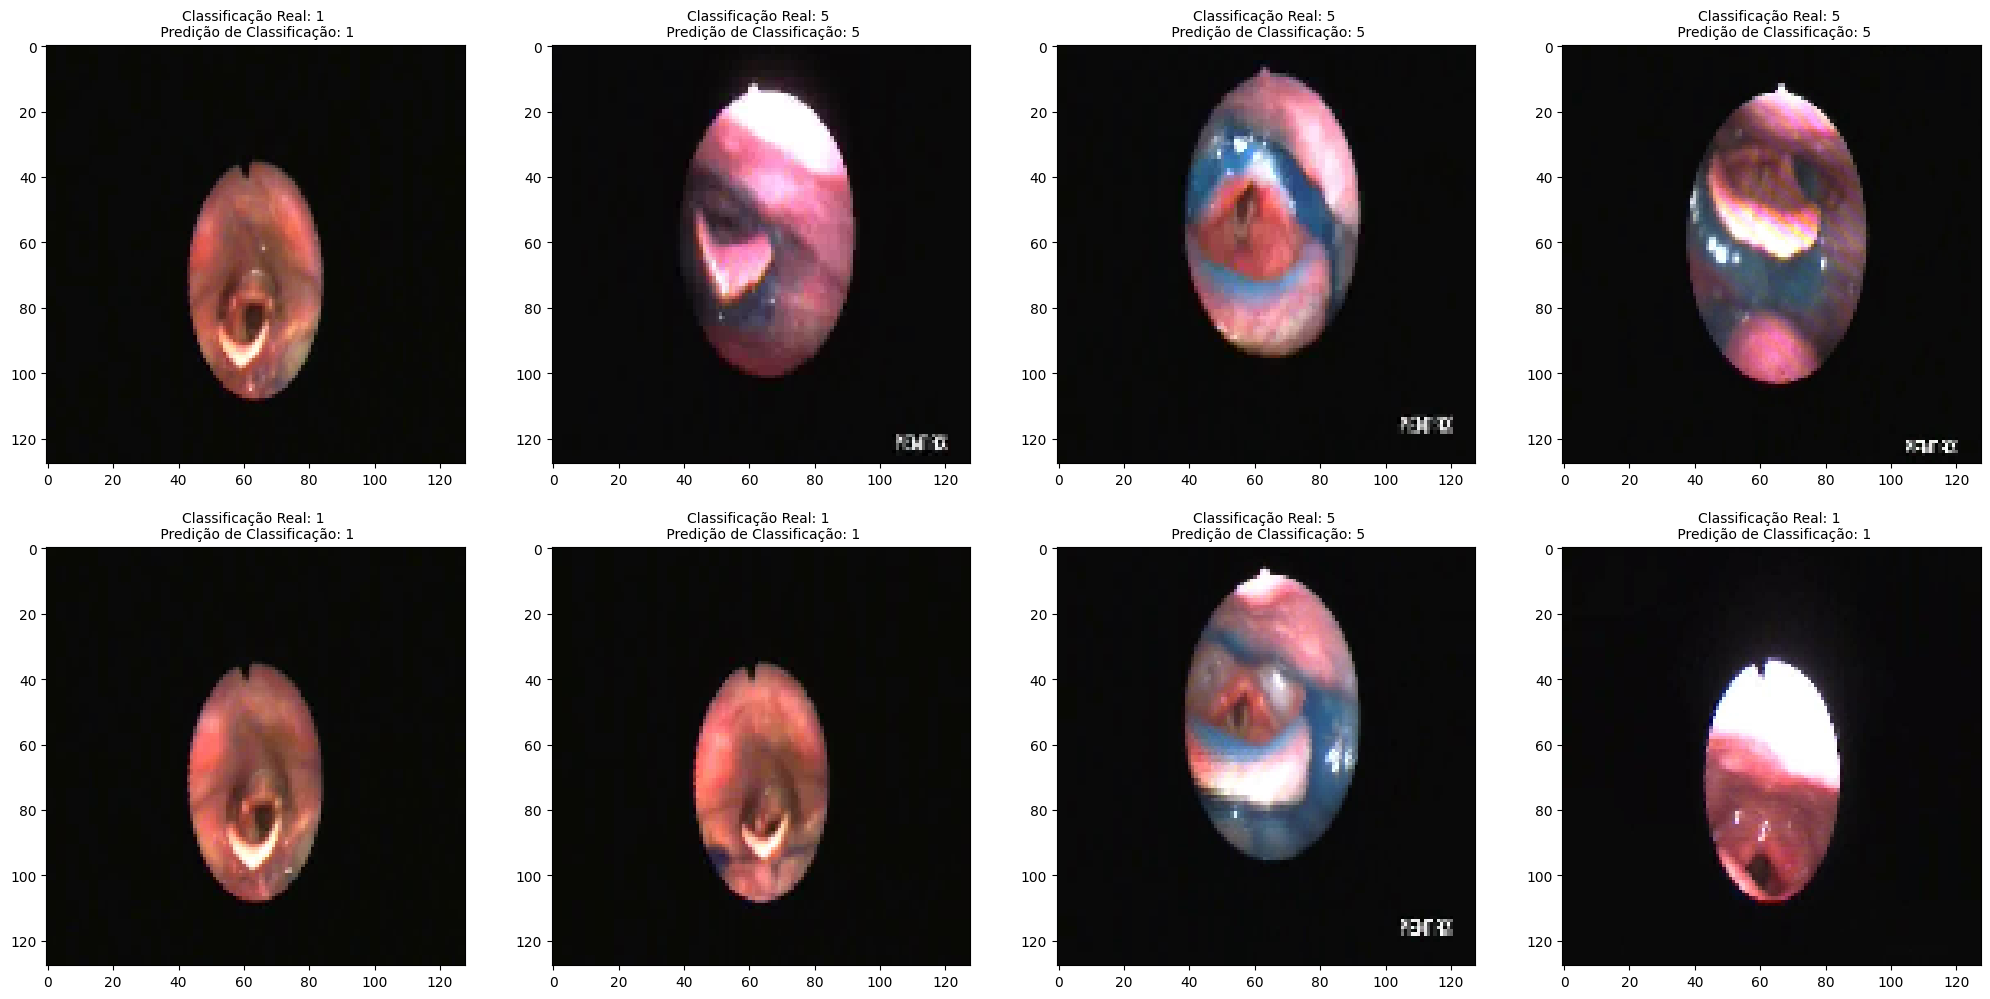

In [ ]:
# visualização das predições

plt.figure(figsize=(25,25))
for i in range(8): #mostrar 8 predições
    ax = plt.subplot(4,4,i+1)
    plt.imshow(test_images1[i])
    plt.title(f"Classificação Real: {class_names[test_labels1[i]]} \n Predição de Classificação: {class_names[test_labels1[i]]}",
             fontsize=10)

In [ ]:
loss,acc = new_model.evaluate(ds_valid)
print(f"the final loss is {loss:.3f}")
print(f"the final accuracy is {acc:.3f}")

3/3 [==============================] - 9s 2s/step - loss: 0.2801 - accuracy: 0.8992
the final loss is 0.280
the final accuracy is 0.899


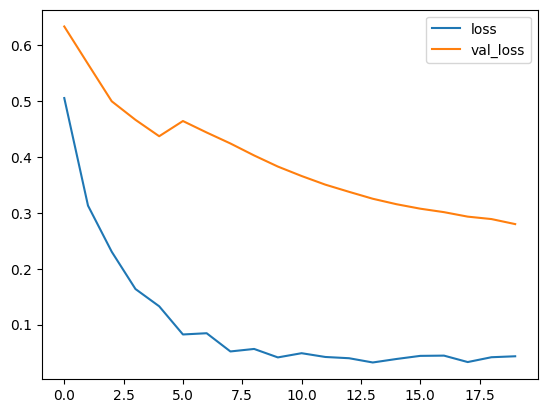

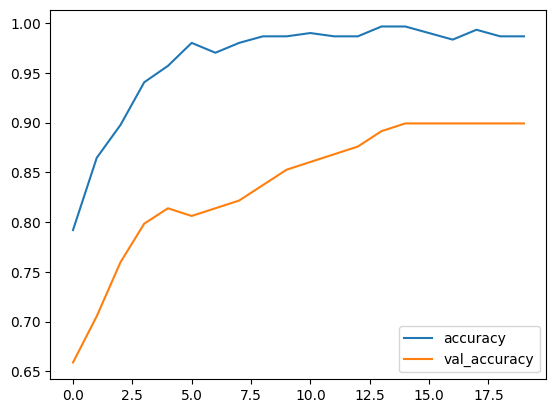

In [ ]:
# curva de aprendizagem

history_frame = pd.DataFrame(history_fine.history)
history_frame.loc[:, ['loss', 'val_loss']].plot()
history_frame.loc[:, ['accuracy', 'val_accuracy']].plot();

In [ ]:
# File path
filepath = '/content/drive/MyDrive/Seios Piriformes/1/01_000042.jpg'

# Load the model
model1 = load_model(filepath, compile = True)

# A few random samples
use_samples = [5, 38, 3939, 27389]
samples_to_predict = []

# Convert into Numpy array
samples_to_predict = np.array(samples_to_predict)

# Generate predictions for samples
predictions = model1.predict(samples_to_predict)
print(predictions)

OSError: ignored